# Music Generation


## Reading Data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Embedding,LSTM,TimeDistributed,Lambda,Dropout,Activation

In [2]:
with open('data/input.txt','r') as file:
    data = file.read()
# print(data)

In [3]:
unique_chars = sorted(set(data))
Vocab_length = len(unique_chars)
print(unique_chars,Vocab_length)

['\n', ' ', '!', '"', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~'] 86


In [4]:
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))
char_to_int;

In [5]:
encoded_text = [char_to_int[value] for value in data]
print(encoded_text[:100])

[51, 25, 1, 16, 0, 47, 25, 28, 1, 58, 71, 61, 1, 31, 0, 5, 1, 41, 72, 77, 77, 66, 71, 64, 65, 58, 70, 1, 40, 78, 76, 66, 60, 1, 31, 58, 77, 58, 59, 58, 76, 62, 0, 46, 25, 32, 33, 0, 52, 25, 28, 29, 0, 40, 25, 19, 14, 19, 0, 38, 25, 28, 0, 40, 25, 21, 14, 23, 0, 43, 25, 28, 0, 63, 84, 3, 28, 3, 62, 60, 60, 1, 60, 17, 63, 84, 3, 28, 3, 62, 60, 60, 1, 60, 17, 63, 84, 3, 28, 3]


In [7]:
# Train Test Split

# Tried this way but the present way is more easy 

# SPLIT_FRAC = 0.751
# SPLIT_IDX = int(len(encoded_text)*SPLIT_FRAC)
# train_encoded_text = encoded_text[:SPLIT_IDX]
# test_encoded_text = encoded_text[SPLIT_IDX:]
# len(train_encoded_text),len(test_encoded_text)

- Preparind batches for train data

In [6]:
BATCH_SIZE = 20
SEQUENCE_LENGTH = 64
# STEP_LENGTH = 1
data_text_length = len(encoded_text)
N_BATCHES = (data_text_length // (BATCH_SIZE * SEQUENCE_LENGTH))
print('Creating ',N_BATCHES,' batches of size ',BATCH_SIZE,' x ',SEQUENCE_LENGTH)

import time
time.sleep(0.3)

Y_values_cat = to_categorical(encoded_text)
X_values= np.zeros([N_BATCHES,BATCH_SIZE,SEQUENCE_LENGTH],dtype=np.int32) #(127, 16, 64)
Y_values= np.zeros([N_BATCHES,BATCH_SIZE,SEQUENCE_LENGTH,Vocab_length]) #(127, 16, 64, 86)

# temp_data = list(range(data_text_length))
for n_b in tqdm(range(N_BATCHES)):
    for n_r in range(BATCH_SIZE):
        for n_e in range(SEQUENCE_LENGTH):
            idx = (n_r*SEQUENCE_LENGTH*N_BATCHES)+(n_b*SEQUENCE_LENGTH)+n_e
            X_values[n_b,n_r,n_e] = encoded_text[idx]
            Y_values[n_b,n_r,n_e] = Y_values_cat[idx+1]
            
print('Created X_values of',X_values.shape,' and y_values of',Y_values.shape)

Creating  101  batches of size  20  x  64


100%|██████████| 101/101 [00:00<00:00, 553.49it/s]

Created X_values of (101, 20, 64)  and y_values of (101, 20, 64, 86)


In [7]:
# Train Test Split
SPLIT_FRAC = 0.75
N_BATCHES_train = int(BATCH_SIZE*SPLIT_FRAC)
N_BATCHES_train
X_train,X_test = X_values[:,:N_BATCHES_train].copy(),X_values[:,N_BATCHES_train:].copy()
Y_train,Y_test = Y_values[:,:N_BATCHES_train].copy(),Y_values[:,N_BATCHES_train:].copy()
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((101, 15, 64), (101, 15, 64, 86), (101, 5, 64), (101, 5, 64, 86))

In [12]:
model=Sequential()
model.add(Embedding(Vocab_length,512,batch_input_shape=(BATCH_SIZE,SEQUENCE_LENGTH)))
model.add(LSTM(256,return_sequences=True,stateful=True))
model.add(Dropout(0.3))
model.add(LSTM(256,return_sequences=True,stateful=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=True,stateful=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(Vocab_length, activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (20, 64, 512)             44032     
_________________________________________________________________
lstm_12 (LSTM)               (20, 64, 256)             787456    
_________________________________________________________________
dropout_12 (Dropout)         (20, 64, 256)             0         
_________________________________________________________________
lstm_13 (LSTM)               (20, 64, 256)             525312    
_________________________________________________________________
dropout_13 (Dropout)         (20, 64, 256)             0         
_________________________________________________________________
lstm_14 (LSTM)               (20, 64, 256)             525312    
_________________________________________________________________
dropout_14 (Dropout)         (20, 64, 256)            

In [13]:
EPOCHS = 500
total_loss = list()
total_acc = list()
for eps in range(EPOCHS):    
    # print('\nEpoch {}/{}'.format(eps + 1, EPOCHS))
    losses, accs = [], []
    for n_batches in range(N_BATCHES):
        loss,acc = model.train_on_batch(X_values[n_batches],Y_values[n_batches])
        losses.append(loss)
        accs.append(acc)
    print('\nEpoch {}/{} --> loss = {}, acc = {}'.format(eps + 1, EPOCHS, np.average(losses), np.average(accs)))
    total_loss.append(np.average(losses))
    total_acc.append(np.average(accs))

model.save('saved_models/model500.h5')


Epoch 1/500 --> loss = 3.203498431951693, acc = 0.1701423270434215

Epoch 2/500 --> loss = 2.345383389161365, acc = 0.33719059411842045

Epoch 3/500 --> loss = 1.902235987162826, acc = 0.4428527246017267

Epoch 4/500 --> loss = 1.7186124348404384, acc = 0.4959158445938979

Epoch 5/500 --> loss = 1.5564737874682586, acc = 0.5299195552816486

Epoch 6/500 --> loss = 1.462399930056959, acc = 0.5458694303979968

Epoch 7/500 --> loss = 1.393007481452262, acc = 0.5599164641139531

Epoch 8/500 --> loss = 1.3430438997721907, acc = 0.5707920766112828

Epoch 9/500 --> loss = 1.2990325842753496, acc = 0.5823251852894774

Epoch 10/500 --> loss = 1.257094698377175, acc = 0.5950262971443705

Epoch 11/500 --> loss = 1.2184118156385895, acc = 0.6066367596682936

Epoch 12/500 --> loss = 1.1834336684481932, acc = 0.6153697418694449

Epoch 13/500 --> loss = 1.1489565006577143, acc = 0.625990100426249

Epoch 14/500 --> loss = 1.1166290215926595, acc = 0.6375618807160028

Epoch 15/500 --> loss = 1.08797840

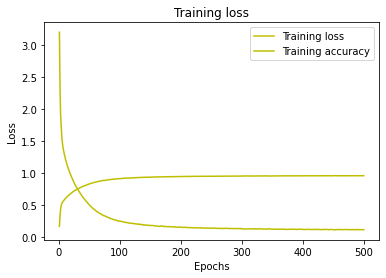

In [15]:
loss = total_loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, total_acc, 'y', label='Training accuracy')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
sample_model=Sequential()
sample_model.add(Embedding(Vocab_length,512,batch_input_shape=(1,1)))
sample_model.add(LSTM(256,return_sequences=True,stateful=True))
sample_model.add(Dropout(0.3))
sample_model.add(LSTM(256,return_sequences=True,stateful=True))
sample_model.add(Dropout(0.2))
sample_model.add(LSTM(256,stateful=True))
sample_model.add(Dropout(0.2))
sample_model.add(Dense(Vocab_length, activation='softmax'))

sample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, 1, 512)               44032     
_________________________________________________________________
lstm (LSTM)                  (1, 1, 256)               787456    
_________________________________________________________________
dropout (Dropout)            (1, 1, 256)               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 1, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (1, 1, 256)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 256)                  525312    
_________________________________________________________________
dropout_2 (Dropout)          (1, 256)                  0

In [9]:
'''Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_4 (Embedding)      (20, 64, 512)             44032     
_________________________________________________________________
lstm_12 (LSTM)               (20, 64, 256)             787456    
_________________________________________________________________
dropout_12 (Dropout)         (20, 64, 256)             0         
_________________________________________________________________
lstm_13 (LSTM)               (20, 64, 256)             525312    
_________________________________________________________________
dropout_13 (Dropout)         (20, 64, 256)             0         
_________________________________________________________________
lstm_14 (LSTM)               (20, 64, 256)             525312    
_________________________________________________________________
dropout_14 (Dropout)         (20, 64, 256)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (20, 64, 86)              22102     
=================================================================
Total params: 1,904,214
Trainable params: 1,904,214
Non-trainable params: 0
_________________________________________________________________''';

In [16]:
def sample_model_maker():
    sample_model=Sequential()
    sample_model.add(Embedding(Vocab_length,512,batch_input_shape=(1,1)))
    sample_model.add(LSTM(256,return_sequences=True,stateful=True))
    sample_model.add(Dropout(0.3))
    sample_model.add(LSTM(256,return_sequences=True,stateful=True))
    sample_model.add(Dropout(0.2))
    sample_model.add(LSTM(256,stateful=True))
    sample_model.add(Dropout(0.2))
    sample_model.add(Dense(Vocab_length, activation='softmax'))
    return sample_model

def sample_maker(n):
    sam_model = sample_model_maker()
    sam_model.load_weights('saved_models/model500.h5')

    output = list()
    for i in tqdm(range(n)):
        inp = np.zeros((1, 1))
        if output:
            inp[0, 0] = output[-1]
        else:
            inp[0, 0] = np.random.randint(Vocab_length)
        result = sam_model.predict(inp)[0]
        sample = np.random.choice(range(Vocab_length), p=result)
        output.append(sample)  
    print(''.join([int_to_char[value] for value in output]))
    
sample_maker(1000)

100%|██████████| 1000/1000 [00:40<00:00, 24.83it/s]

M:6/8
K:D
A|"D"FED FED|FGA d2A|"G"Bcd "D"AGF|"Em"GEE "A7"E2A|
"D"FED FED|"D"FGA A2A|"G"Bcd "D"Adf|"A7"edc "D"d2:|
P:B
A|"D"d2f a2f|"G"b2g "A7"a2f|"D"def agf|"D"f3 "D7"a3|"G"b2g "A7"efg|\
"D"a2f "Bm"d2A|"D"d2e f2d|"D"d3 fed|"A"dec A2e|
"D"f2A ABA|"Em"G2G F2E|"A7"ABA GFE|"D"D3 -D2||


X: 176
T:Liberty Bell
% Nottingham Music Database
S:FTB, via EF
Y:AB
M:6/8
K:A
P:A
|:E|"A"E2E EAB|"A"c3 A3|"A"c3 A2c|"Bm"B2c "E"d2B|"A"c3 E2A|"A"c2e ABc|"Bm"daf "E7"edB|
"A"Ace a2g|"D"agf "A"edc|"E7"edB "A"A2:|
P:B
B|"A"c2e efe|"A"ecA Ace|"D"fgf fgf|"A"ecA A2c/2d/2|
"D"agf "F#m"ecc|"Bm"B2c "E7"B2A|"A"Ace aae|"Bm"b2g "E7"fed|"A"c3 -c2E|"D"d2e f2e|
"A"a2e c2A|"A"Ace a3|"D"agf "A"edc|"E7"edB "A"A2:|


X: 303
T:The Stone Court
% Nottingham Music Database
S:Chris Dewhurst 1989, via Phil Rowe
M:6/8
K:Am
"Am"A3 a3|"Em"gee e2d|"C"c2g edc|"G"Bgd -dBG|"Am"A3 "F"a3|"C"gee e2d|\
"Dm"c2e "E7"dcB| [1"Am"A3 -AcB:|
 [2"Am" A3 -"G7"A2|||:B|"C"c3 -cef|"C"g3 e2d|"C"c2d e2d|"C"e3 z3|"G"d^cd B3|
"A7"^c3 A3|"Dm"d2d "G"def|"G"g2f

In [ ]:
# sample_model=Sequential()
# sample_model.add(Embedding(Vocab_length,512,batch_input_shape=(1,1)))
# sample_model.add(LSTM(256,return_sequences=True,stateful=True))
# sample_model.add(Dropout(0.3))
# sample_model.add(LSTM(256,return_sequences=True,stateful=True))
# sample_model.add(Dropout(0.2))
# sample_model.add(LSTM(256,stateful=True))
# sample_model.add(Dropout(0.2))
# sample_model.add(Dense(Vocab_length, activation='softmax'))

# sample_model.load_weights('saved_models/model300.h5')


# output = [np.reshape(np.random.randint(Vocab_length),(1,1))]
# for i in tqdm(range(1000)):
#     inp = output[-1]
#     result = sample_model.predict(inp)[0]
#     sample = np.random.choice(range(Vocab_length), p=result)
#     sample = sample.reshape(1,1)
#     output.append(sample)  
# print(''.join([int_to_char[value[0][0]] for value in output]))

### Sir's Code

In [156]:
def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y
        
def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

def give_sample(num_chars,idx_to_char,vocab_size):
    model = build_sample_model(vocab_size)
    model.load_weights('saved_models/sirmodel.h5')

    sampled = list()

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)
    return sampled
    # return ''.join(idx_to_char[c] for c in sampled)

In [114]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

text = open('data/input.txt','r').read()
char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
vocab_size = len(char_to_idx)
T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32)

model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
model.summary();
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

E = 100
for epoch in range(E):
    # print('\nEpoch {}/{}'.format(epoch + 1, E))
    
    losses, accs = [], []
         
    for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
        loss, acc = model.train_on_batch(X, Y)
        # print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
        losses.append(loss)
        accs.append(acc)
    print('\nEpoch {}/{}: loss = {}, acc = {}'.format(epoch + 1, E, loss, acc))
model.save('saved_models/sirmodel.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (16, 64, 512)             44032     
_________________________________________________________________
lstm_36 (LSTM)               (16, 64, 256)             787456    
_________________________________________________________________
dropout_36 (Dropout)         (16, 64, 256)             0         
_________________________________________________________________
lstm_37 (LSTM)               (16, 64, 256)             525312    
_________________________________________________________________
dropout_37 (Dropout)         (16, 64, 256)             0         
_________________________________________________________________
lstm_38 (LSTM)               (16, 64, 256)             525312    
_________________________________________________________________
dropout_38 (Dropout)         (16, 64, 256)           

### TOdo

we have trained this model using train_on_batch function


so now we need to try by direct .fit() method